In [20]:
import unittest
import sys
sys.path.append('../funpipe')
import os
from subprocess import check_call
import numpy as np
import pandas as pd
import filecmp

from utils import run
from fasta import fasta
from fastq import fastq
from gatk import gatk
from vcf import vcf
from gt_pair import gt_pair
from vcfheader import vcfheader
from vcfrecord import vcfrecord
from plink import plink
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
vcf_complex  = vcf( 'data/phy_test.vcf',prefix='complex',outdir='data' )
#vcf_complex.get_plink()

[W::bcf_hdr_check_sanity] GL should be declared as Number=G


In [4]:
#compute dosage matrix
vcf_complex.cal_dos()

 - Done: bcftools query -f '[%GT ]\n' data/phy_test.vcf>data/complex.dos.tsv



bcftools query -f '[%GT ]\n' data/phy_test.vcf>data/complex.dos.tsv
[W::bcf_hdr_check_sanity] GL should be declared as Number=G
[W::vcf_parse] Contig '1' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'X' is not defined in the header. (Quick workaround: index the file with tabix.)


In [5]:
dosage_matrix = vcf_complex.dosage_matrix

In [6]:
def get_total(l1, l2):
    count = 0
    for i in range(len(l1)):
        if not( l1[i] == '0/0' and l2[i] == '0/0' ):
            count = count+1
    return count

def get_shared(l1, l2):
    count = 0
    for i in range(len(l1)):
        if not( l1[i] == '0/0' and l2[i] == '0/0' ):
            if l1[i] == l2[i]:
                count = count + 1
    return count

def get_unique(l1,l2):
    return get_total(l1,l2) - get_shared(l1,l2)
    

In [21]:
#compute pairwise shared and unique variants
pairwise_shared = np.zeros( (vcf_complex.n_samples,vcf_complex.n_samples) )
pairwise_unique = np.zeros( (vcf_complex.n_samples,vcf_complex.n_samples) )

In [22]:
for i in range(vcf_complex.n_samples):
    for j in range(vcf_complex.n_samples):
        pairwise_shared[i][j] = get_shared(list(dosage_matrix[i]),list(dosage_matrix[j]) )
        pairwise_unique[i][j] = get_unique( list(dosage_matrix[i]),list(dosage_matrix[j]) )

In [23]:
vcf_complex.get_sample_info(info=['GT'])

bcftools query -f  '%CHROM	%POS	%REF	%ALT[	%GT]
' data/phy_test.vcf > data/complex.sample_info.tsv
[W::bcf_hdr_check_sanity] GL should be declared as Number=G
[W::vcf_parse] Contig '1' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'X' is not defined in the header. (Quick workaround: index the file with tabix.)


 - Done: bcftools query -f  '%CHROM	%POS	%REF	%ALT[	%GT]
' data/phy_test.vcf > data/complex.sample_info.tsv



In [24]:
sample_info = vcf_complex._sample_info
samples = ['A','B','C','D']

Text(87.0, 0.5, 'samples')

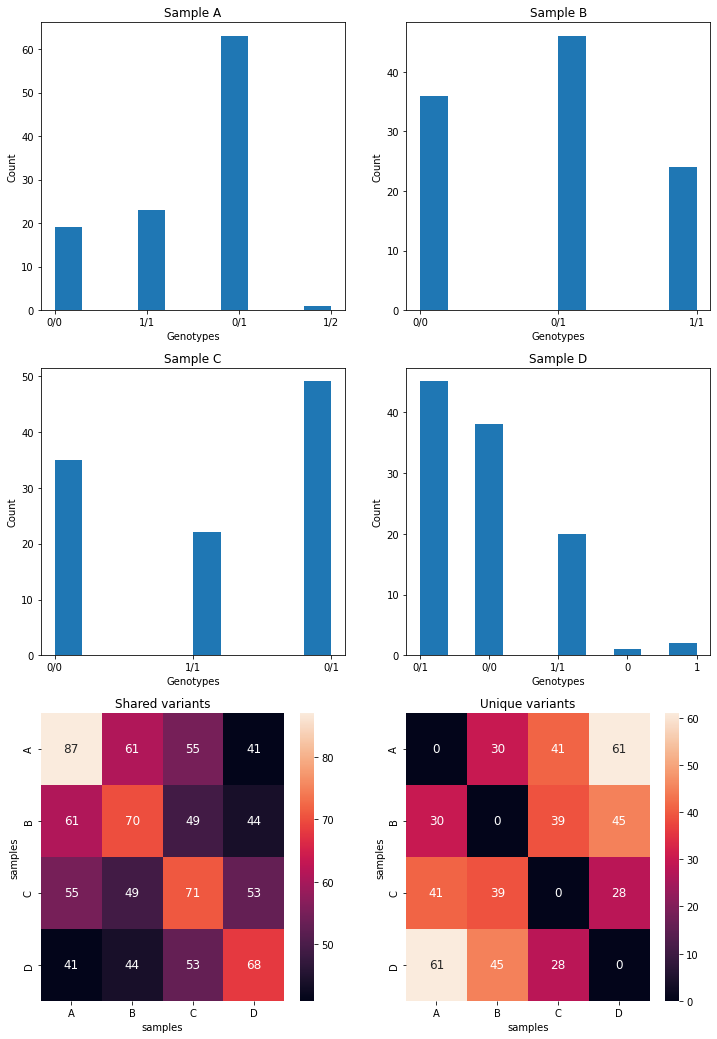

In [38]:
fig,axs = plt.subplots(3,2,figsize=(12,18))
for i in range(4):
    x_c = int(i/2)
    y_c = int(i%2)
    axs[x_c][y_c].hist(sample_info['GT_'+samples[i]])
    axs[x_c][y_c].set_xlabel('Genotypes')
    axs[x_c][y_c].set_ylabel('Count')
    axs[x_c][y_c].set_title('Sample '+samples[i])
    
sns.heatmap(pairwise_shared,annot=True,annot_kws={'fontsize':12},yticklabels=samples,
                xticklabels=samples,ax = axs[2][0] )

sns.heatmap(pairwise_unique,annot=True,annot_kws={'fontsize':12},yticklabels=samples,
                xticklabels=samples,ax=axs[2][1] )
axs[2][0].set_title('Shared variants')
axs[2][1].set_title('Unique variants')
axs[2][1].set_xlabel('samples')
axs[2][0].set_xlabel('samples')
axs[2][1].set_ylabel('samples')
axs[2][0].set_ylabel('samples')